### Estimating the Regional and Residual Gravity Data using the equivalent layer and a Polynomial Function 
#### Here, I REDUCED the equivalent layer to CHECK the edge effects at the borders of the data
##### RESULTS: 
This notebook shows that the reducing the equivalent layer to an area inside the area of the grid data the predicted regional has a large edge effect at the border of the area of the equivalent layer


###### This notebook reads synthetic data (synthetic-data.txt) which were previously created by the notebook 
###### Equivalent_Layer_Larissa_Regional.ipynb
###### This notebook estimates the regional component of gravity data and calculates the residual component of the gravity data



###### OBS:  Não consegui ler quando não há regional adicionado. O problema é o typo da variável Regional_Information 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
#import datetime
from datetime import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af
import auxiliary_functions_Larissa_Project as af_L

import fatiando
from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.gravmag.eqlayer import EQLGravity
from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang, contaminate, dircos
from fatiando.constants import G, SI2MGAL,SI2EOTVOS

C:\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
C:\Anaconda2\lib\site-packages\fatiando\vis\myv.py:53: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


Executed auxiliary_functions_Larissa_Project.py


In [2]:
from numpy import linalg
from scipy.optimize import nnls
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.stats import norm


In [3]:
saved_files = [] #list of saved files

In [4]:
def Matrix_Polynomial(x,y,order):
    assert (xp.size == yp.size), 'xp and yp must have the same size '
    assert (order == 1) or (order == 2), ' Create First- or Second-orders polynomials'
    if order == 1:
        B_Poly[:,0] = 1.
        B_Poly[:,1] = x
        B_Poly[:,2] = y
    elif order ==2:
        B_Poly[:,0] = 1.
        B_Poly[:,1] = x
        B_Poly[:,2] = y
        B_Poly[:,3] = x**2
        B_Poly[:,4] = x*y
        B_Poly[:,5] = y**2
               
    return B_Poly
    

In [5]:
notebook_name = 'Estimate_Regional_Gravity_Data_Reduced_EqLayer.ipynb'

In [6]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: ac2afbcb2d99b18f145cc1ed40075beb5f92dd5a


In [7]:
with open('../data/model_single.pickle') as f:
        full_model = pickle.load(f)

In [8]:
with open('../data/regular_grid.pickle') as f:
        regular_grid = pickle.load(f)

In [9]:
print regular_grid['shape'][0], regular_grid['shape'][1]

100 80


In [10]:
regular_grid['area']

[-10000, 10000, -8000, 8000]

In [27]:
# Data Grid information 
regular_grid

{'DS': 40915.483953458635,
 'N': 8000,
 'area': [-10000, 10000, -8000, 8000],
 'metadata': 'Generated by computation_points.ipynb on 30 May 2018 17:31:52 UTC',
 'shape': (100, 80),
 'spacing': [202.02020202020202, 202.53164556962025]}

In [11]:
regular_grid_EqLayer = dict() #empty dictionary

In [14]:
# REDUCED the equivalent layer to avoid the edge effects at the borders of the data

# Compute percent of the dimension of the area

percent_area = 25.


North_dimension    =  (regular_grid['area'][1]-regular_grid['area'][0])
North_added_border =  North_dimension * percent_area/100.
print North_dimension, North_added_border

East_dimension    =  (regular_grid['area'][3]-regular_grid['area'][2])
East_added_border =  East_dimension * percent_area/100.
print East_dimension, East_added_border

#area over which the equivalent layer is calculated
#x minimum, x maximum, y minimum and y maximum
x_eqlayer_min = regular_grid['area'][0]+North_added_border 
x_eqlayer_max = regular_grid['area'][1]-North_added_border 
y_eqlayer_min = regular_grid['area'][2]+East_added_border
y_eqlayer_max = regular_grid['area'][3]-East_added_border

regular_grid_EqLayer['area_EqLayer'] = [x_eqlayer_min, x_eqlayer_max, y_eqlayer_min, y_eqlayer_max]

#number of sources along the x and y directions is equal to the number of the grid of data
regular_grid_EqLayer['shape_EqLayer'] = (regular_grid['shape'][0], regular_grid['shape'][1])

# A different number of sources along the x and y directions can be set
#regular_grid_EqLayer['shape_EqLayer'] = (50,40)

# Total number of sources 
regular_grid_EqLayer['M_source'] = regular_grid_EqLayer['shape_EqLayer'][0]*regular_grid_EqLayer['shape_EqLayer'][1]

#source spacing along the y and x directions
regular_grid_EqLayer['spacing_EqLayer'] = gridder.spacing(regular_grid_EqLayer['area_EqLayer'], regular_grid_EqLayer['shape_EqLayer'])

#element of area in the equivalent layer
regular_grid_EqLayer['DS_EqLayer'] = regular_grid_EqLayer['spacing_EqLayer'][0]*regular_grid_EqLayer['spacing_EqLayer'][1]

20000 5000.0
16000 4000.0


In [15]:
regular_grid_EqLayer

{'DS_EqLayer': 10228.870988364659,
 'M_source': 8000,
 'area_EqLayer': [-5000.0, 5000.0, -4000.0, 4000.0],
 'shape_EqLayer': (100, 80),
 'spacing_EqLayer': [101.01010101010101, 101.26582278481013]}

In [16]:
#auxiliary informations about the Equivalent Layer 
now = datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
regular_grid_EqLayer['metadata_EqLayer'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [18]:
print now

18 July 2018 18:52:40 UTC


In [19]:
#save the Equivalent Layer by using the Python pickle module (https://docs.python.org/2/library/pickle.html)
file_name = '..\\data\\regular_grid_EqLayer.pickle'
with open(file_name, 'w') as fs:
    pickle.dump(regular_grid_EqLayer, fs)
saved_files.append(file_name)

In [20]:
for rs in regular_grid_EqLayer:
    print rs, ':', regular_grid_EqLayer[rs]

spacing_EqLayer : [101.01010101010101, 101.26582278481013]
DS_EqLayer : 10228.8709884
metadata_EqLayer : Generated by Estimate_Regional_Gravity_Data_Reduced_EqLayer.ipynb on 18 July 2018 18:52:40 UTC
M_source : 8000
shape_EqLayer : (100, 80)
area_EqLayer : [-5000.0, 5000.0, -4000.0, 4000.0]


In [21]:
#coordinates x and y of the Equivalent Layer
xs, ys = regular(regular_grid_EqLayer['area_EqLayer'], regular_grid_EqLayer['shape_EqLayer'])

-10000 10000 -8000 8000


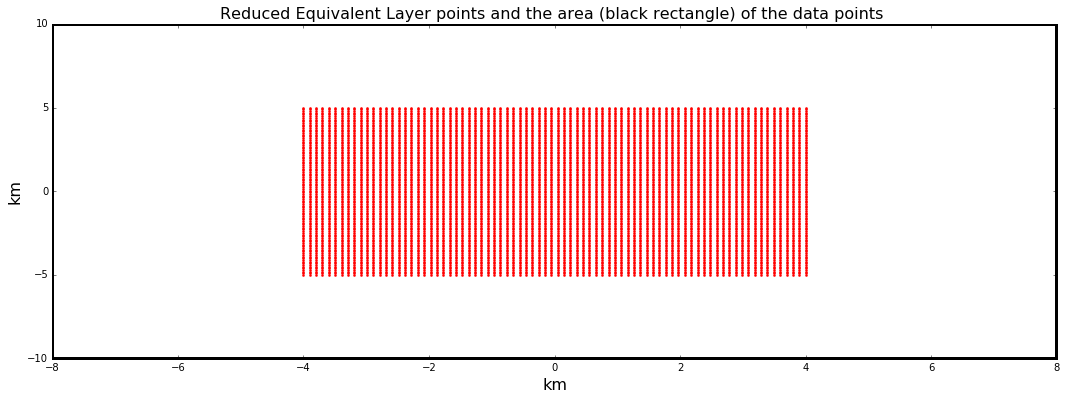

In [23]:
plt.figure(figsize=(18, 6))

km = 1000.
plt.plot(ys/km,xs/km, 'r.', markersize = 4)
regular_grid['area'][0]

yy1, yy2, xx1, xx2 = regular_grid['area'][0], regular_grid['area'][1], regular_grid['area'][2], regular_grid['area'][3]
print yy1, yy2, xx1, xx2

ax = plt.gca() 
x_data_project  = [xx1/km, xx1/km, xx2/km, xx2/km, xx1/km]
y_data_project  = [yy1/km, yy2/km, yy2/km, yy1/km, yy1/km]
ax.plot(x_data_project, y_data_project, '-k' , linewidth = 4)
ax.set_xlabel('km', fontsize = 16)
ax.set_ylabel('km', fontsize = 16)
ax.set_title('Reduced Equivalent Layer points and the area (black rectangle) of the data points ', fontsize = 16)




####  Open data file

In [24]:
with open('../data/synthetic-data.txt') as f:
    for i in range(2):
        f.readline()
    line = f.readline()
    shape = map(int, line.split()[1:])
    print(shape)
    Regional_Information = f.readline()
    print(Regional_Information), type(Regional_Information)  
    if Regional_Information is not None:
        xp, yp, zp, data, Regional, gz = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 3, 4, 5])                     
    else: 
        xp, yp, zp, gz = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 3])     
    

[100, 80]
    FIRST-ORDER POLYNOMIAL
<type 'str'>


In [25]:
### Ploting (1) Original Data (2) Regional and (3) Data+Regional

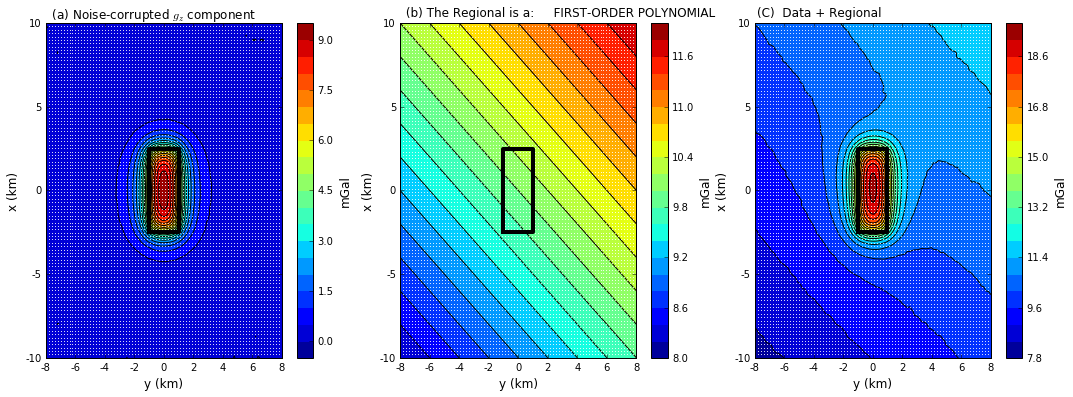

In [26]:
plt.figure(figsize=(18, 6))
unit_handle = 'mGal'

if (Regional_Information is None):
    print 'Data Without Regional Background'
    print '\n No regional map \n '
    af_L.Plot_Onemap(xp, yp, gz, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title='Noise-corrupted $g_z$ component', 
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = unit_handle)
elif ('CONSTANT' in Regional_Information):
    print("REGIONAL INFORMATION ADDED TO THE ORIGINAL DATA WAS: {}".format(Regional_Information))
    print '\n'+Regional_Information+'  =  %4.3f \n' %Regional[0]
    print '\n No regional map \n '
    
    af_L.Plot_Twomaps(xp, yp, data, gz, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Noise-corrupted $g_z$ component", 
                figure_title2 = " (b) Data + Regional - The Regional is a: {}".format(Regional_Information),
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')
elif('FIRST-ORDER POLYNOMIAL' in Regional_Information) or ('SECOND-ORDER POLYNOMIAL' in Regional_Information):
    af_L.Plot_Threemaps(xp, yp, data, Regional, gz, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Noise-corrupted $g_z$ component", 
                figure_title2 = " (b) The Regional is a: {}".format(Regional_Information),
                figure_title3 = "(C)  Data + Regional",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 12.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')

    

In [29]:
#horizontal plane containing the equivalent sources located at plano_fonte 
plano_fonte=400.
zs = np.zeros_like(xs) + plano_fonte

M_source = regular_grid_EqLayer['M_source'] 

assert (xs.size == M_source) and (ys.size == M_source) and (zs.size == M_source),  \
                'xs, ys and zs must have the same size defined by M_source'

print 'number of the equivalent sources at the equivalent layer: ', M_source

number of the equivalent sources at the equivalent layer:  8000


In [30]:
Npts = len(gz)
print 'number of data: Npts', Npts


print 'number of equivalent sources: ', M_source



number of data: Npts 8000
number of equivalent sources:  8000


In [31]:
# Computing the sensitivity matrix by row

A_GZ = np.empty((Npts,M_source),dtype = float)

for i in range(Npts):
    A_GZ[i,:] = af_L.AZ(xp[i], yp[i], zp[i], xs,ys,zs)
   

In [32]:
now = datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')

start_time_ATA = datetime.now() 

ATA = np.empty((M_source,M_source),dtype =float)
ATA = np.dot(A_GZ.T, A_GZ)


end_time_ATA  = datetime.now()
print('Duration ATA: {}'.format(end_time_ATA  - start_time_ATA ))  

# Gradient

start_time_ATd = datetime.now() 

ATdo = np.dot(A_GZ.T,gz)

end_time_ATd  = datetime.now()
print('Duration Atd: {}'.format(end_time_ATd  - start_time_ATd ))  

Duration ATA: 0:00:06.565000
Duration Atd: 0:00:00.017000


In [33]:
print type(A_GZ), len(A_GZ)

<type 'numpy.ndarray'> 8000


### Creating a polinomial matrix
$ \bf{B} $

In [34]:
# Creating a polinomial matrix


B_Poly = np.empty((M_source,3),dtype =float)

order_poly = 1
if order_poly == 1:
    B_Poly = np.empty((M_source,3),dtype =float)
elif order_poly == 2:
    B_Poly = np.empty((M_source,6),dtype =float)

B_Poly = Matrix_Polynomial(xs,ys,order_poly)


### Computing: sensitivity matrix multiplied by Polynomial matrix
$ \bf{G} \bf{B} $

In [35]:
GB = np.dot(A_GZ, B_Poly)

# Hessian Matrix without the regularizing function
BTGTGB =  np.dot(GB.T,GB)
# Gradient vector
BGTdo  =  np.dot(GB.T,gz)


In [36]:
reg_parameter = 0.0000000000000000000001

#reg_parameter = 0.0000000000000001

#reg_parameter = 0.00001

In [37]:
if order_poly == 1:
    n_coef = 3
elif order_poly == 2:
    n_coef = 6

Hessiana  = BTGTGB + diags([reg_parameter], 0, (n_coef,n_coef), format='csr', dtype='float')

c_estimate = linalg.solve(Hessiana,BGTdo)


#### Compute the predicted parameter of the regional (equation 9 PEL)
$  \bf{B} \bf{c} = \bf{p} $

In [38]:
# predicted parameter by the regional equation 9 PEL

print c_estimate

p_regional_estimated = np.dot(B_Poly,c_estimate)

[  3.89810581e+09   4.19176581e+04   4.40994674e+04]


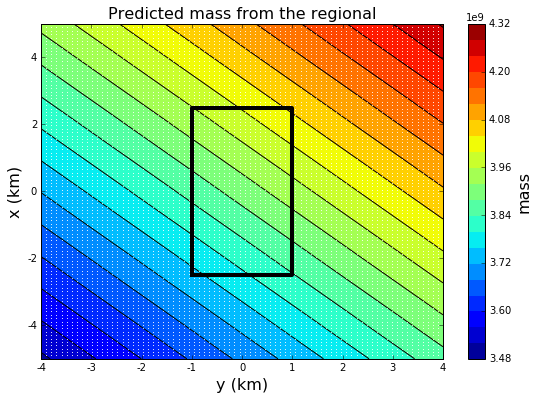

In [39]:
plt.figure(figsize=(9, 6))
unit_handle = 'mass'

af_L.Plot_Onemap(xs, ys, p_regional_estimated, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title='Predicted mass from the regional', 
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = unit_handle)

#### Compute the predicted Regional gravity data $ \bf{g^R} $  by using equation 14 PEL
$  \bf{GB} \bf{c} = \bf{g^R} $

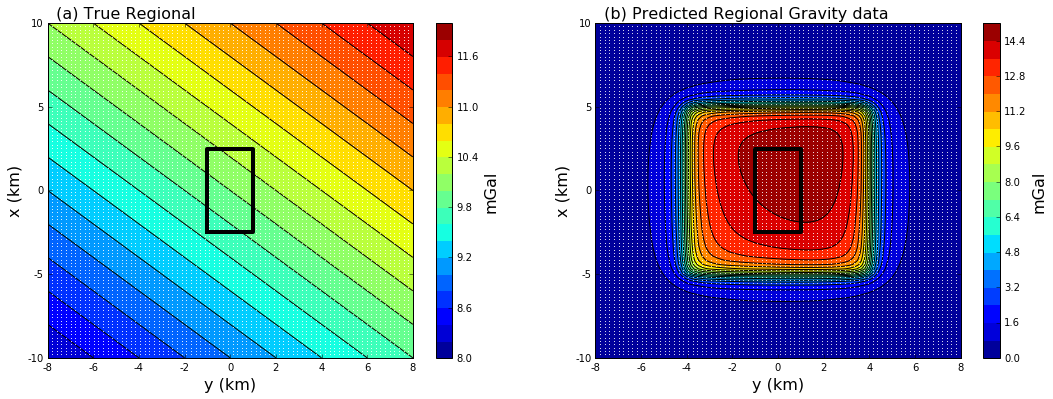

In [40]:
# Compute the predicted Regional gravity data by using equation 14 PEL

predicted_gravity_regional = np.dot(GB,c_estimate)


plt.figure(figsize=(18, 6))
unit_handle = 'mGal'

af_L.Plot_Twomaps(xp, yp, Regional, predicted_gravity_regional, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) True Regional ",
                figure_title2 = " (b) Predicted Regional Gravity data",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')

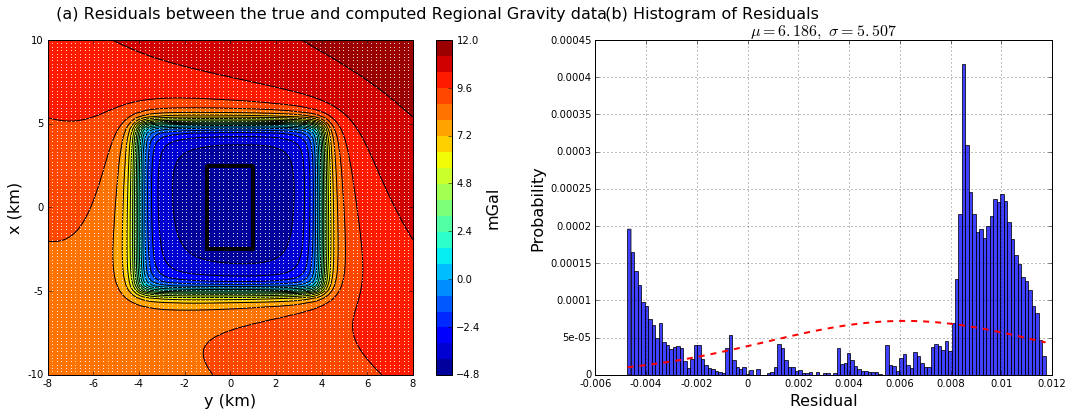

In [41]:
plt.figure(figsize=(18, 6))
unit_handle = 'mGal'
af_L.Plot_Onemap_Histog(xp, yp, Regional - predicted_gravity_regional, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Residuals between the true and computed Regional Gravity data ",
                figure_title2 = " (b) Histogram of Residuals ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')
    
   

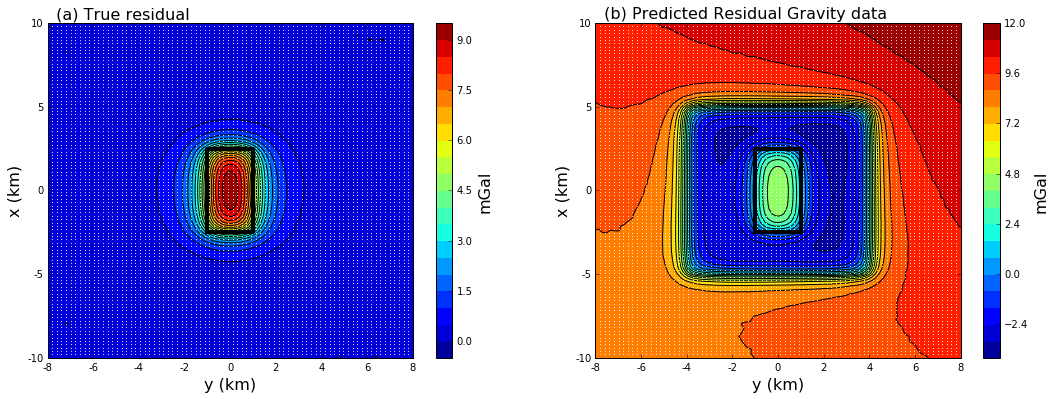

In [42]:
# Compute the Residual = Observed - Predicted gravity data by using equation 14 PEL

Residual_gravity = gz - predicted_gravity_regional 


plt.figure(figsize=(18, 6))
unit_handle = 'mGal'

af_L.Plot_Twomaps(xp, yp, data, Residual_gravity, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) True residual ",
                figure_title2 = " (b) Predicted Residual Gravity data",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')

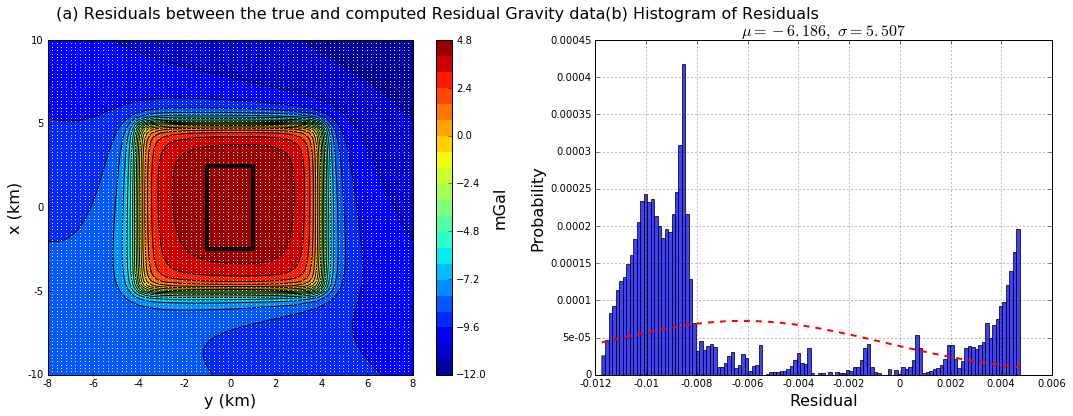

In [43]:
plt.figure(figsize=(18, 6))
unit_handle = 'mGal'
af_L.Plot_Onemap_Histog(xp, yp, data - Residual_gravity, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Residuals between the true and computed Residual Gravity data",
                figure_title2 = " (b) Histogram of Residuals ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')
    